# Video Segmentation Data

This is a demonstration of a single simulation of SEM on a single video.  In practice, this simulation is repeated in multiple batches and over three videos.  We only include one for simplicity and computational resources.

For reasons of space, we have only included the processed video data (embedded with a VAE) in the github repository. The VAE and the code to create this embedding can be found in a seperate repository: [ProjectSEM/VAE-video](https://github.com/ProjectSEM/VAE-video)





In [1]:
# ## comment out if running locally and SEM is already installed
# !pip install git+https://github.com/nicktfranklin/SEM2

# # we will use data that we keep in the repository, so we need to clone
# # it if running on Colab
# !git clone https://github.com/nicktfranklin/SEM2.git 

In [2]:
import sys
print("Python version")
print (sys.version)

Python version
3.7.9 (default, Aug 31 2020, 07:22:35) 
[Clang 10.0.0 ]


In [3]:
import os
os.chdir('../')


In [4]:
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
from sem import sem_run
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

TensorFlow Version: 2.3.1


In [5]:
Z = np.load('./data/videodata/video_color_Z_embedded_64_5epoch.npy')


# # the "Sax" movie is from time slices 0 to 5537
# sax = Z[0:5537, :]  # uncomment to use the "saxaphone video"
# bed = Z[5537:5537 + 10071, :]  # uncomment to use the "making the bed"
dishes = Z[5537 + 10071: 5537 + 10071 + 7633, :]
# Z = None


# x = sax[0:1500]
# x = sax
x = dishes


In [6]:
# Load Human comparison data, used later

def bin_times(array, max_seconds, bin_size=1.0):
    """ Helper function to learn the bin the subject data"""
    cumulative_binned = [np.sum(array <= t0 * 1000) for t0 in np.arange(bin_size, max_seconds + bin_size, bin_size)]
    binned = np.array(cumulative_binned)[1:] - np.array(cumulative_binned)[:-1]
    binned = np.concatenate([[cumulative_binned[0]], binned])
    return binned

def load_comparison_data(data, bin_size=1.0):

    # Movie A is Saxaphone (185s long)
    # Movie B is making a bed (336s long)
    # Movie C is doing dishes (255s long)

    # here, we'll collapse over all of the groups (old, young; warned, unwarned) for now
    n_subjs = len(set(data.SubjNum))

    sax_times = np.sort(list(set(data.loc[data.Movie == 'A', 'MS']))).astype(np.float32)
    binned_sax = bin_times(sax_times, 185, bin_size) / np.float(n_subjs)

    bed_times = np.sort(list(set(data.loc[data.Movie == 'B', 'MS']))).astype(np.float32)
    binned_bed = bin_times(bed_times, 336, bin_size) / np.float(n_subjs)

    dishes_times = np.sort(list(set(data.loc[data.Movie == 'C', 'MS']))).astype(np.float32)
    binned_dishes = bin_times(dishes_times, 255, bin_size) / np.float(n_subjs)

    return binned_sax, binned_bed, binned_dishes

human_data_path = './data/'
data = pd.read_csv(human_data_path + 'zachs2006_data021011.dat', delimiter='\t')
_, _, binned_dishes = load_comparison_data(data)
Z = None



In [7]:
# set the parameters for the segmentation
# f_class = GRUEvent


# these are the parameters for the event model itself.
f_opts=dict(
    var_df0=10., 
    var_scale0=0.06, 
    l2_regularization=0.0, 
    dropout=0.5,
    n_epochs=10,
    t=4
)


lmda = 10**4  # stickyness parameter (prior)
alfa = 10**-1 # concentration parameter (prior)

sem_init_kwargs = {'lmda': lmda, 'alfa': alfa, 'f_opts': f_opts}

In [8]:
# run the model
sem_results = sem_run(x, sem_init_kwargs)

Run SEM: 100%|██████████| 7633/7633 [25:36<00:00,  4.97it/s]  


In [9]:
# from sem import SEM
# sem_model = SEM(**sem_init_kwargs)
# sem_model.run(x)
# sem_results = sem_model.results

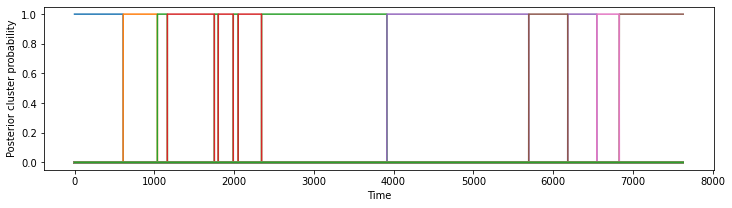

In [10]:
# get the MAP event models
y_hat = sem_results.e_hat

plt.figure(figsize=(12, 3.0))
plt.plot(sem_results.post)
plt.gca().set_ylabel('Posterior cluster probability')
plt.gca().set_xlabel('Time')
plt.show()
# tf.Session().close()

In [11]:
# these are custom analysis functions

def bin_times(array, max_seconds, bin_size=1.0):
    cumulative_binned = [
        np.sum(array <= t0 * 1000) for t0 in np.arange(bin_size, max_seconds + bin_size, bin_size)
    ]
    binned = np.array(cumulative_binned)[1:] - np.array(cumulative_binned)[:-1]
    binned = np.concatenate([[cumulative_binned[0]], binned])
    return binned


def get_subjs_rpb(data, bin_size=1.0):
    # get the grouped data
    grouped_data = np.concatenate(load_comparison_data(data))
    
    r_pbs = []
    
    for sj in set(data.SubjNum):
        _binned_sax =  bin_times(data.loc[(data.SubjNum == sj) & (data.Movie == 'A'), 'MS'], 185, 1.0)
        _binned_bed =  bin_times(data.loc[(data.SubjNum == sj) & (data.Movie == 'B'), 'MS'], 336, 1.0)
        _binned_dishes =  bin_times(data.loc[(data.SubjNum == sj) & (data.Movie == 'C'), 'MS'], 255, 1.0)
        subs = np.concatenate([_binned_sax, _binned_bed, _binned_dishes])
        
        r_pbs.append(get_point_biserial(subs, grouped_data))
    return r_pbs
    


In [12]:
# get the point biserial correlation coefficient

def get_binned_boundaries(posterior, bin_size=1.0, frequency=30.0):
    
    e_hat = np.argmax(sem_results.post, axis=1)
    
    frame_time = np.arange(1, len(e_hat) + 1) / float(frequency)
    index = np.arange(0, np.max(frame_time), bin_size)

    boundaries = np.concatenate([[0], e_hat[1:] !=e_hat[:-1]])

    boundaries_binned = []
    for t in index:
        boundaries_binned.append(np.sum(
            boundaries[(frame_time >= t) & (frame_time < (t + bin_size))]
        ))
    return np.array(boundaries_binned, dtype=bool) 

def get_point_biserial(boundaries_binned, binned_comp):
    M_1 = np.mean(binned_comp[boundaries_binned == 1])
    M_0 = np.mean(binned_comp[boundaries_binned == 0])

    n_1 = np.sum(boundaries_binned == 1)
    n_0 = np.sum(boundaries_binned == 0)
    n = n_1 + n_0

    s = np.std(binned_comp)
    r_pb = (M_1 - M_0) / s * np.sqrt(n_1 * n_0 / (float(n)**2))
    return r_pb

boundaries = get_binned_boundaries(sem_results.post)

get_point_biserial(boundaries, binned_dishes)

0.23094745275080888

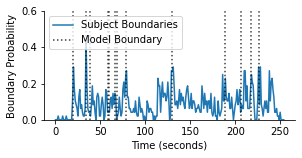

In [13]:
plt.figure(figsize=(4.5, 2.0))
plt.plot(binned_dishes, label='Subject Boundaries')
plt.xlabel('Time (seconds)')
plt.ylabel('Boundary Probability')

b = np.arange(len(boundaries))[boundaries][0]
plt.plot([b, b], [0, 1], 'k:', label='Model Boundary', alpha=0.75)
for b in np.arange(len(boundaries))[boundaries][1:]:
    plt.plot([b, b], [0, 1], 'k:', alpha=0.75)

plt.legend(loc='upper left')
plt.ylim([0, 0.6])
sns.despine()


In [14]:
# from video_segmentation import load_comparison_data
# human_data_path = './data/'
# data = pd.read_csv(human_data_path + 'zachs2006_data021011.dat', delimiter='\t')
# binned_sax, binned_bed, binned_dishes = load_comparison_data(data, bin_size=1.0)

array([130, 238, 211, 210,  79, 131,  20, 228, 226,  34])

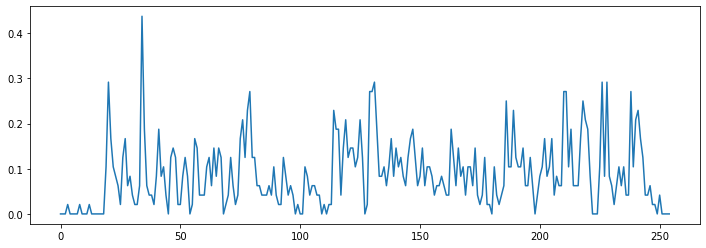

In [15]:
plt.figure(figsize=(12, 4))
plt.plot(binned_dishes, alpha=1.0)
np.argsort(binned_dishes)[-10:]

0.5656171932224218

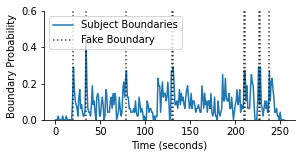

In [16]:
fake_boundaries = np.zeros(np.shape(binned_dishes), dtype=bool) 
fake_boundaries[np.argsort(binned_dishes)[-10:]] = True

plt.figure(figsize=(4.5, 2.0))
plt.plot(binned_dishes, label='Subject Boundaries')
plt.xlabel('Time (seconds)')
plt.ylabel('Boundary Probability')

b = np.arange(len(fake_boundaries))[fake_boundaries][0]
plt.plot([b, b], [0, 1], 'k:', label='Fake Boundary', alpha=0.75)
for b in np.arange(len(fake_boundaries))[fake_boundaries][1:]:
    plt.plot([b, b], [0, 1], 'k:', alpha=0.75)

plt.legend(loc='upper left')
plt.ylim([0, 0.6])
sns.despine()

get_point_biserial(fake_boundaries, binned_dishes)

Maximum possible r_pb: 0.8056334426110205


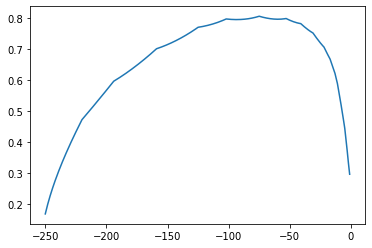

In [17]:
r_pb = []
for ii in range(-250, 0, 1):
    fake_boundaries = np.zeros(np.shape(binned_dishes), dtype=bool) 
    fake_boundaries[np.argsort(binned_dishes)[ii:]] = True
    r_pb.append(get_point_biserial(fake_boundaries, binned_dishes))
plt.plot(range(-250, 0, 1), r_pb)
print("Maximum possible r_pb: {}".format(np.max(r_pb)))

In [18]:
from scipy.special import logsumexp
def get_binned_boundary_prop(log_post, bin_size=1.0, frequency=30.0):
    """
    :param results: sem_results
    :param bin_size: seconds
    :param frequency: in Hz
    :return:
    """
    
    e_hat = np.argmax(log_post, axis=1)

    # normalize
    log_post0 = log_post - np.tile(np.max(log_post, axis=1).reshape(-1, 1), (1, log_post.shape[1]))
    log_post0 -= np.tile(logsumexp(log_post0, axis=1).reshape(-1, 1), (1, log_post.shape[1]))

    boundary_probability = [0]
    for ii in range(1, log_post0.shape[0]):
        idx = list(range(log_post0.shape[0]))
        idx.remove(e_hat[ii - 1])
        boundary_probability.append(logsumexp(log_post0[ii, idx]))
    boundary_probability = np.array(boundary_probability)

    frame_time = np.arange(1, len(boundary_probability) + 1) / float(frequency)

    index = np.arange(0, np.max(frame_time), bin_size)
    boundary_probability_binned = []
    for t in index:
        boundary_probability_binned.append(
            # note: this operation is equivalent to the log of the average boundary probability in the window
            logsumexp(boundary_probability[(frame_time >= t) & (frame_time < (t + bin_size))]) - \
            np.log(bin_size * 30.)
        )
    boundary_probability_binned = pd.Series(boundary_probability_binned, index=index)
    return boundary_probability_binned

boundary_prop = get_binned_boundary_prop(sem_results.log_prior + sem_results.log_like)

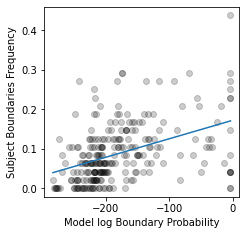

In [19]:
plt.figure(figsize=(3.5, 3.5))
plt.scatter(boundary_prop, binned_dishes, color='k', alpha=0.2)
plt.ylabel('Subject Boundaries Frequency')
plt.xlabel('Model log Boundary Probability')
x = boundary_prop
y = binned_dishes
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))


In [20]:
r_pbs = get_subjs_rpb(data)

In [21]:
# get the permutation r_pb
_boundaries = np.copy(boundaries)
n_permute = 500
r_pb_permuted = []
for ii in range(n_permute):
    np.random.shuffle(_boundaries)
    r_pb_permuted.append(get_point_biserial(_boundaries, binned_dishes))

/Users/nicholasfranklin/opt/anaconda3/envs/schema/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


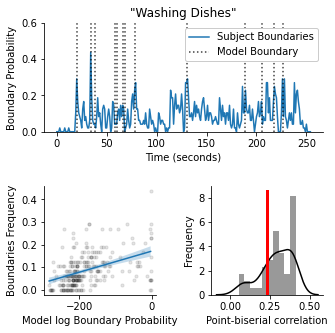

In [22]:
import statsmodels.api as sm
from scipy import stats


plt.figure(figsize=(5.0, 5.0))
ax = plt.subplot2grid((2, 2), (0, 0), colspan=2)

plt.plot(binned_dishes, label='Subject Boundaries')
plt.xlabel('Time (seconds)')
plt.ylabel('Boundary Probability')

b = np.arange(len(boundaries))[boundaries][0]
plt.plot([b, b], [0, 1], 'k:', label='Model Boundary', alpha=0.75)
for b in np.arange(len(boundaries))[boundaries][1:]:
    plt.plot([b, b], [0, 1], 'k:', alpha=0.75)

plt.legend(loc='upper right', framealpha=1.0)
plt.ylim([0, 0.6])
plt.title('"Washing Dishes"')
sns.despine()

ax = plt.subplot2grid((2, 2), (1, 0), colspan=1)
plt.scatter(boundary_prop, binned_dishes, color='k', s=10, alpha=0.1)
plt.ylabel('Boundaries Frequency')
plt.xlabel('Model log Boundary Probability')
x = boundary_prop
y = binned_dishes
y = y[np.argsort(x)]
x = np.sort(x)
X = sm.add_constant(x)
mod = sm.OLS(y, X)
res = mod.fit()
y_hat = res.predict(X)
plt.plot(x, res.predict(X))

n = len(y_hat)
dof = n - res.df_model - 1
t = stats.t.ppf(1-0.025, df=dof)
s_err = np.sum(np.power(y - y_hat, 2))
conf = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((x-np.mean(x)),2) /
            ((np.sum(np.power(x,2))) - n*(np.power(np.mean(x),2))))))

upper = y_hat + abs(conf)
lower = y_hat - abs(conf)
plt.fill_between(x, lower, upper, alpha=0.25)

ax = plt.subplot2grid((2, 2), (1, 1), colspan=1)
x = 'Model Subjects'.split()
sns.distplot(r_pbs,  ax=ax, norm_hist=False, label='Subjects', bins=10, color='k')
r_pb_model = get_point_biserial(boundaries, binned_dishes)
lb, ub = ax.get_ylim()
plt.plot([r_pb_model, r_pb_model], [0, ub], 'r', label='Model', lw='3')
plt.xlabel(r'Point-biserial correlation')
plt.ylabel('Frequency')

plt.subplots_adjust(hspace=0.5, wspace=0.5)
sns.despine()
# plt.savefig('Segmentation_dishes.pdf', dpi=600, bbox_inches='tight')